<a href="https://colab.research.google.com/github/ccg-esb-lab/MDR_IS_Model/blob/main/MonodGillespieIS_multispecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multispecies Stochastic Model: Structure and Core Reactions

This notebook introduces the multispecies Gillespie-based model used in the study. It describes how
birth, death, mutation, IS transposition, plasmid segregation, and conjugation are implemented under
resource limitation, and illustrates how these processes interact across bacterial species.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm      # used for colormaps
import pandas as pd
import seaborn as sns           # used for heatmaps / distributions
import pickle                   # used for loading params
import os                       # filesystem paths
from pathlib import Path        # repo-relative paths
from matplotlib.patches import Wedge  # used in pie-chart subpopulation plots
import sys

In [2]:

# Clone repo if it is not already present
repo_url = "https://github.com/jorgEVOplasmids/MDR_ISs.git"
repo_name = "MDR_ISs"

if not Path(repo_name).exists():
    !git clone {repo_url}

REPO_ROOT = Path(repo_name).resolve()
print("Repo root:", REPO_ROOT)


pathCODE    = REPO_ROOT / "Computational_model/code/"
pathPARAMS  = REPO_ROOT / "Computational_model/data/"
pathFIGURES = REPO_ROOT / "Computational_model/figures/"
pathSIM     = REPO_ROOT / f"Computational_model/runs/"

print("pathCODE:", pathCODE)
print("pathPARAMS:", pathPARAMS)
print("pathFIGURES:", pathFIGURES)
print("pathSIM:", pathSIM)

# Make sure output dirs exist
pathFIGURES.mkdir(parents=True, exist_ok=True)
pathSIM.mkdir(parents=True, exist_ok=True)


Cloning into 'MDR_IS_Model'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 51 (delta 23), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 2.60 MiB | 4.33 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Repo root: /content/MDR_IS_Model
pathCODE: /content/MDR_IS_Model/code
pathPARAMS: /content/MDR_IS_Model/data
pathFIGURES: /content/MDR_IS_Model/figures
pathSIM: /content/MDR_IS_Model/runs
Module loaded successfully!


In [ ]:

sys.path.append(str(pathCODE))
import MonodGillespieIS_multispecies as mg
print("Module loaded successfully!")


## Evolutionary model


In [3]:
def gillespie_bacterial_growth_multi_species(
    strains, populations_0, populations_p, antibiotic_concentration,
    initial_resource, simulation_time, dt=0.1, verbose=False
):
    """
    Simulates bacterial growth for multiple species with plasmid-free and plasmid-bearing populations.
    Includes resource competition and inter-species plasmid conjugation.

    Parameters:
    strains (dict): Dictionary with parameters for plasmid-free ("0") and plasmid-bearing ("p") strains for each species.
    populations_0 (np.array): 3D array of plasmid-free populations [species][SNP][IS].
    populations_p (np.array): 3D array of plasmid-bearing populations [species][SNP][IS].
    antibiotic_concentration (float): Antibiotic concentration in the environment.
    initial_resource (float): Initial shared resource concentration.
    simulation_time (float): Total simulation time.
    dt (float): Time step for the simulation.

    Returns:
    tuple: Time values, population values, and resource values during the simulation.
    """
    t = 0
    R = initial_resource  # Shared resource pool
    num_species, num_mutationsSNP, num_mutationsIS = populations_0.shape

    # Tracking results
    t_values = [t]
    population_values = [(populations_0.copy(), populations_p.copy())]
    resource_values = [R]

    while t < simulation_time and R > 0 and (
        np.sum(populations_0) > 0 or np.sum(populations_p) > 0
    ):
        if verbose:
            print(f"--- Time {t:.2f} ---")
            print(f"Resource level: {R:.2f}")
            print(f"Total plasmid-free population: {np.sum(populations_0)}")
            print(f"Total plasmid-bearing population: {np.sum(populations_p)}")

        for species in range(num_species):
            if verbose:
                print(f"\nProcessing species {species}...")

            # Initialize counters for events
            births, deaths, mutations, transpositions, segregations, conjugations = 0, 0, 0, 0, 0, 0

            # Process plasmid-free populations
            for k, strain in enumerate(strains[species]["0"]):
                i, j = divmod(k, num_mutationsIS)
                half_saturation_resource = strain['half_saturation_resource']
                half_saturation_antibiotic = strain['half_saturation_antibiotic']

                # Effective birth rate
                birth_rate_eff = strain['birth_rate'] * (R / (R + half_saturation_resource))
                birth_rate_eff = max(birth_rate_eff, 0)

                # Expected births
                expected_births = (
                    max(0, np.random.poisson(birth_rate_eff * populations_0[species, i, j] * dt))
                    if populations_0[species, i, j] > 0 else 0
                )
                births += expected_births

                # Effective death rate
                death_rate_eff = strain['death_rate'] * (
                    antibiotic_concentration / (antibiotic_concentration + half_saturation_antibiotic)
                )
                death_rate_eff = max(death_rate_eff, 0)

                # Expected deaths
                expected_deaths = (
                    max(0, np.random.poisson(death_rate_eff * populations_0[species, i, j] * dt))
                    if populations_0[species, i, j] > 0 else 0
                )
                deaths += expected_deaths

                # Update population
                populations_0[species, i, j] = max(
                    0, populations_0[species, i, j] + expected_births - expected_deaths
                )
                populations_0[species, i, j] = (
                    populations_0[species, i, j] if populations_0[species, i, j] >= 1 else 0
                )

                # Resource consumption
                R = max(0, R - expected_births * strain['consumption_rate'])

                # Mutations and transpositions
                if strain['mutation_rate'] > 0 and i < num_mutationsSNP - 1:
                    mutation_events = np.random.poisson(strain['mutation_rate'] * populations_0[species, i, j])
                    populations_0[species, i, j] = max(0, populations_0[species, i, j] - mutation_events)
                    populations_0[species, i + 1, j] += mutation_events
                    mutations += mutation_events

                if strain['transposition_rate'] > 0 and j < num_mutationsIS - 1:
                    transposition_events = np.random.poisson(strain['transposition_rate'] * populations_0[species, i, j])
                    populations_0[species, i, j] = max(0, populations_0[species, i, j] - transposition_events)
                    populations_0[species, i, j + 1] += transposition_events
                    transpositions += transposition_events

            # Process plasmid-bearing populations
            for k, strain in enumerate(strains[species]["p"]):
                i, j = divmod(k, num_mutationsIS)
                half_saturation_resource = strain['half_saturation_resource']
                half_saturation_antibiotic = strain['half_saturation_antibiotic']

                # Effective birth rate
                birth_rate_eff = strain['birth_rate'] * (R / (R + half_saturation_resource))
                birth_rate_eff = max(birth_rate_eff, 0)

                # Expected births
                expected_births = (
                    max(0, np.random.poisson(birth_rate_eff * populations_p[species, i, j] * dt))
                    if populations_p[species, i, j] > 0 else 0
                )
                births += expected_births

                # Effective death rate
                death_rate_eff = strain['death_rate'] * (
                    antibiotic_concentration / (antibiotic_concentration + half_saturation_antibiotic)
                )
                death_rate_eff = max(death_rate_eff, 0)

                # Expected deaths
                expected_deaths = (
                    max(0, np.random.poisson(death_rate_eff * populations_p[species, i, j] * dt))
                    if populations_p[species, i, j] > 0 else 0
                )
                deaths += expected_deaths

                # Update population
                populations_p[species, i, j] = max(
                    0, populations_p[species, i, j] + expected_births - expected_deaths
                )
                populations_p[species, i, j] = (
                    populations_p[species, i, j] if populations_p[species, i, j] >= 1 else 0
                )

                # Resource consumption
                R = max(0, R - expected_births * strain['consumption_rate'])

                # Mutations, transpositions, segregations, and conjugations
                if strain['mutation_rate'] > 0 and i < num_mutationsSNP - 1:
                    mutation_events = np.random.poisson(strain['mutation_rate'] * populations_p[species, i, j])
                    populations_p[species, i, j] = max(0, populations_p[species, i, j] - mutation_events)
                    populations_p[species, i + 1, j] += mutation_events
                    mutations += mutation_events

                if strain['transposition_rate'] > 0 and j < num_mutationsIS - 1:
                    transposition_events = np.random.poisson(strain['transposition_rate'] * populations_p[species, i, j])
                    populations_p[species, i, j] = max(0, populations_p[species, i, j] - transposition_events)
                    populations_p[species, i, j + 1] += transposition_events
                    transpositions += transposition_events

                # Segregations
                segregation_events = np.random.poisson(strain['segregation_rate'] * expected_births)
                populations_p[species, i, j] = max(0, populations_p[species, i, j] - segregation_events)
                populations_0[species, i, j] += segregation_events
                segregations += segregation_events

                # Inter-species conjugations using plasmid transmission matrix
                for target_species in range(num_species):
                    if plasmid_matrix[species, target_species] > 0:  # Ensure conjugation is allowed
                        for m in range(num_mutationsSNP):
                            for n in range(num_mutationsIS):
                                #print(f"Species {species} → Target Species {target_species}, Conjugation Rate: {plasmid_matrix[species, target_species]}")

                                # Use the transmission matrix value instead of fixed conjugation rate
                                conjugation_events = np.random.poisson(
                                    plasmid_matrix[species, target_species] *
                                    populations_p[species, i, j] * populations_0[target_species, m, n] * dt
                                )

                                # Update populations
                                populations_0[target_species, m, n] = max(0, populations_0[target_species, m, n] - conjugation_events)
                                populations_p[target_species, m, n] += conjugation_events
                                conjugations += conjugation_events


            # Print event statistics for the species
            if verbose:
                print(f"Species {species} summary:")
                print(f"  Births: {births}")
                print(f"  Deaths: {deaths}")
                print(f"  Mutations: {mutations}")
                print(f"  Transpositions: {transpositions}")
                print(f"  Segregations: {segregations}")
                print(f"  Conjugations: {conjugations}")

        # Update time and store results
        t += dt
        t_values.append(t)
        population_values.append((populations_0.copy(), populations_p.copy()))
        resource_values.append(R)

    return t_values, population_values, resource_values


In [4]:
def runSimulationIS_multi_species(strains, initial_populations_0, initial_populations_p, num_days, antibiotic_concentration, initial_resource, simulation_time, dilution=0.1, verbose=False):
    results = []

    # Initialize populations
    populations_0 = np.array(initial_populations_0, dtype=float).copy()
    populations_p = np.array(initial_populations_p, dtype=float).copy()

    for day in range(num_days):
        # Simulate one day
        time_points, population_values, resource_values = gillespie_bacterial_growth_multi_species(
            strains, populations_0, populations_p, antibiotic_concentration, initial_resource, simulation_time, 0.1, verbose
        )

        # Save results
        day_results = {
            'day': day + 1,
            'time_points': time_points,
            'final_populations_0': population_values[-1][0],  # Last state of plasmid-free populations
            'final_populations_p': population_values[-1][1],  # Last state of plasmid-bearing populations
            'resource': resource_values[-1]
        }
        results.append(day_results)

        # Apply dilution for the next day
        populations_0 *= dilution
        populations_p *= dilution

        # Stop if all populations are extinct
        if np.all(populations_0 <= 0) and np.all(populations_p <= 0):
            print(f"All populations went to zero on day {day + 1}. Stopping simulation.")
            break

    return results




# Numerical experiments

### Parameters


In [5]:

# Define parameters for each mutation-transposition level
num_mutationsSNP = 3  # Number of mutation levels
num_mutationsIS = 3  # Number of transposition levels

# Set initial resource, max time, and antibiotic concentration
initial_resource = 1.0
simulation_time = 24.0
B0=1e8

# Shared parameters
num_days = 60
dilution_factor = 0.1  # dilution factor applied each day

num_reps = 3
days=range(0, num_days + 1)

strainIDs = ["K253", "K168", "K037", "K241", "K209"]  # Species IDs
species_colors=['orange','blue', 'green', 'purple',  'yellow']

### Load params

In [6]:

num_species = len(strainIDs)  # Number of species (e.g., "E" and "K")
strains_species = {}  # Initialize the dictionary to store strains for each species

for species_idx, strainID in enumerate(strainIDs):
    # Define the file paths for plasmid-free and plasmid-bearing strain parameters
    file_0 = f'params_{strainID}_0.pkl'
    file_p = f'params_{strainID}_p.pkl'

    #file_0 = f'params_E_0.pkl'
    #file_p = f'params_E_p.pkl'

    # Load plasmid-free strains (strains_0) from the .pkl file
    with open(os.path.join(pathPARAMS, file_0), 'rb') as f:
        strains_0 = pickle.load(f)
    print(f"Plasmid-free parameters for strain {strainID} loaded successfully from:\n{os.path.join(pathPARAMS, file_0)}\n")

    # Load plasmid-bearing strains (strains_p) from the .pkl file
    with open(os.path.join(pathPARAMS, file_p), 'rb') as f:
        strains_p = pickle.load(f)
    print(f"Plasmid-bearing parameters for strain {strainID} loaded successfully from:\n{os.path.join(pathPARAMS, file_p)}\n")

    # Add the loaded strains to strains_species dictionary
    strains_species[species_idx] = {
        "0": strains_0,  # Plasmid-free parameters
        "p": strains_p   # Plasmid-bearing parameters
    }

Plasmid-free parameters for strain K253 loaded successfully from:
/content/MDR_IS_Model/data/params_K253_0.pkl

Plasmid-bearing parameters for strain K253 loaded successfully from:
/content/MDR_IS_Model/data/params_K253_p.pkl

Plasmid-free parameters for strain K168 loaded successfully from:
/content/MDR_IS_Model/data/params_K168_0.pkl

Plasmid-bearing parameters for strain K168 loaded successfully from:
/content/MDR_IS_Model/data/params_K168_p.pkl

Plasmid-free parameters for strain K037 loaded successfully from:
/content/MDR_IS_Model/data/params_K037_0.pkl

Plasmid-bearing parameters for strain K037 loaded successfully from:
/content/MDR_IS_Model/data/params_K037_p.pkl

Plasmid-free parameters for strain K241 loaded successfully from:
/content/MDR_IS_Model/data/params_K241_0.pkl

Plasmid-bearing parameters for strain K241 loaded successfully from:
/content/MDR_IS_Model/data/params_K241_p.pkl

Plasmid-free parameters for strain K209 loaded successfully from:
/content/MDR_IS_Model/data

### Define initial conditions

In [7]:
def initialize_populations(num_species, num_mutationsSNP, num_mutationsIS, strainIDs, initial_values_by_strain=None, default_initial_values={"0": 1e6, "p": 0}):
    """
    Initialize populations for multiple species based on strain-specific or default initial values.

    Parameters:
    - num_species (int): Number of species.
    - num_mutationsSNP (int): Number of SNP mutation levels.
    - num_mutationsIS (int): Number of IS transposition levels.
    - strainIDs (list): List of strain IDs.
    - initial_values_by_strain (dict): Initial values for each strain (optional).
    - default_initial_values (dict): Default initial values (optional).

    Returns:
    - populations_0 (np.array): Initial plasmid-free populations.
    - populations_p (np.array): Initial plasmid-bearing populations.
    """

    # Use default initial values if none are provided
    if default_initial_values is None:
        default_initial_values = {"0": 1e6, "p": 100}

    if initial_values_by_strain is None:
        initial_values_by_strain = {}

    # Initialize populations
    populations_0 = np.zeros((num_species, num_mutationsSNP, num_mutationsIS))  # Plasmid-free
    populations_p = np.zeros((num_species, num_mutationsSNP, num_mutationsIS))  # Plasmid-bearing

    # Assign initial populations
    for species_idx, strainID in enumerate(strainIDs):
        # Get initial values for the current strain, falling back to defaults
        strain_initial_values = initial_values_by_strain.get(strainID, default_initial_values)

        # Assign populations to the first mutation and transposition level
        populations_0[species_idx, 0, 0] = strain_initial_values.get("0", 0)
        populations_p[species_idx, 0, 0] = strain_initial_values.get("p", 0)

    return populations_0, populations_p




initial_values_by_strain = {
    "K253": {"0": 1e6, "p": 0},     # Initial densities
    "K168": {"0": 1e6, "p": 0},     # Initial densities
    "K037": {"0": 1e6, "p": 0},      # Initial densities
     "K241": {"0": 1e6, "p": 100},      # Initial densities
     "K209": {"0": 1e6, "p": 0},      # Initial densities
}

# Define initial conditions
populations_0, populations_p = initialize_populations(
    num_species=num_species,
    num_mutationsSNP=num_mutationsSNP,
    num_mutationsIS=num_mutationsIS,
    strainIDs=strainIDs,
    initial_values_by_strain=initial_values_by_strain
)


### Run simulation

In [8]:
# Define the plasmid transmission matrix
eps=1e-9
plasmid_matrix = np.array([
    [eps, eps, eps, eps, eps],  # K253 can transfer to K168, K037, and K209
    [eps, eps, eps, eps, eps],  # K168 can transfer to K253, K037,
    [eps, eps, eps, eps, eps],   # K037 can transfer to K253 and K168
    [eps, eps, eps, eps, eps],   # K241 can transfer to K168 and K209
    [eps, eps, eps, eps, eps],   # K209 can transfer to K253
])

# Convert to Pandas DataFrame for better visualization
df_plasmid = pd.DataFrame(plasmid_matrix, index=strainIDs, columns=strainIDs)

# Display the matrix
print(df_plasmid)

              K253          K168          K037          K241          K209
K253  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09
K168  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09
K037  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09
K241  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09
K209  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09


In [9]:
# Run many simulaitons and compute mean
def runManySimulations(num_reps, runSimulationIS_multi_species, strains, initial_populations_0, initial_populations_p, num_days, antibiotic_concentration, initial_resource, simulation_time, dilution_factor):
    """
    Runs the simulation multiple times and computes the mean of final populations and resource values across repetitions.

    Parameters:
    num_reps (int): Number of repetitions of the simulation.
    runSimulationIS_multi_species (function): The simulation function to run.
    strains (list): List of strain parameters.
    initial_populations_0 (list): Initial plasmid-free populations.
    initial_populations_p (list): Initial plasmid-bearing populations.
    num_days (int): Number of simulation days.
    antibiotic_concentration (float): Antibiotic concentration used in the simulation.
    initial_resource (float): Initial resource concentration.
    simulation_time (float): Total simulation time.
    dilution_factor (float): Dilution factor applied daily.

    Returns:
    list: Averaged results for each day, containing mean `final_populations_0`, `final_populations_p`, and `resource`.
    """
    # List to store results from all repetitions
    all_results = []

    # Run simulations and collect results
    for rep in range(num_reps):
        print("Simulation %s"%(rep+1))
        results = runSimulationIS_multi_species(
            strains=strains,
            initial_populations_0=initial_populations_0,
            initial_populations_p=initial_populations_p,
            num_days=num_days,
            antibiotic_concentration=antibiotic_concentration,
            initial_resource=initial_resource,
            simulation_time=simulation_time,
            dilution=dilution_factor,
            verbose=False
        )
        all_results.append(results)

    # Initialize mean results
    num_days = len(all_results[0])
    mean_results = []
    for day_idx in range(num_days):
        mean_results.append({
            'day': day_idx + 1,
            'final_populations_0': None,
            'final_populations_p': None,
            'resource': None
        })

    # Compute means for each day
    for day_idx in range(num_days):
        # Initialize accumulators
        sum_pop_0 = None
        sum_pop_p = None
        sum_resource = 0

        for rep in range(num_reps):
            day_result = all_results[rep][day_idx]

            if sum_pop_0 is None:
                sum_pop_0 = np.zeros_like(day_result['final_populations_0'])
            if sum_pop_p is None:
                sum_pop_p = np.zeros_like(day_result['final_populations_p'])

            sum_pop_0 += day_result['final_populations_0']
            sum_pop_p += day_result['final_populations_p']
            sum_resource += day_result['resource']

        # Compute averages
        mean_results[day_idx]['final_populations_0'] = sum_pop_0 / num_reps
        mean_results[day_idx]['final_populations_p'] = sum_pop_p / num_reps
        mean_results[day_idx]['resource'] = sum_resource / num_reps

    return mean_results


simulation_time=24
antibiotic_concentration=0.2

results = runManySimulations(
    num_reps=num_reps,
    runSimulationIS_multi_species=runSimulationIS_multi_species,
    strains=strains_species,
    initial_populations_0=populations_0,
    initial_populations_p=populations_p,
    num_days=num_days,
    antibiotic_concentration=antibiotic_concentration,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    dilution_factor=dilution_factor
)


Simulation 1
Simulation 2
Simulation 3


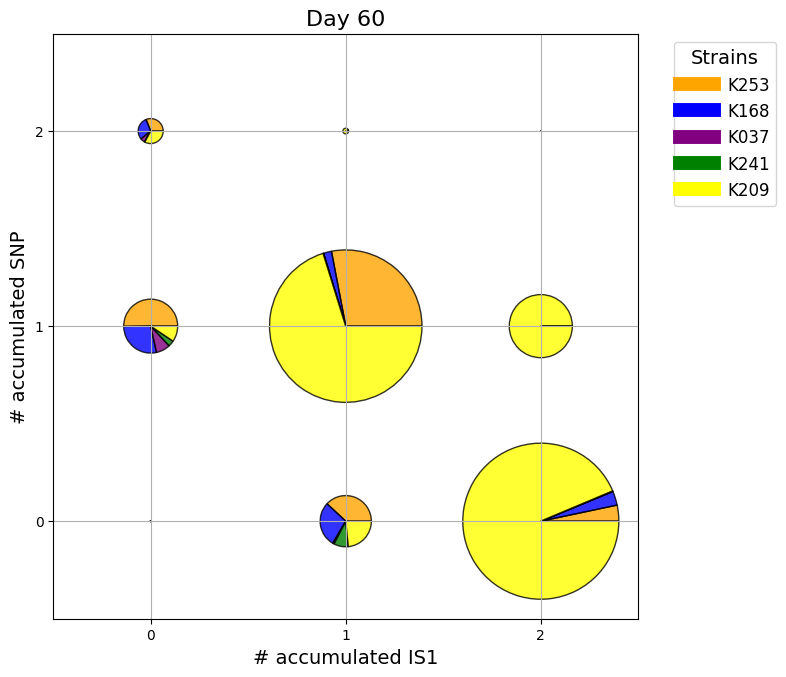

In [10]:
def extractSubpopulationDensitiesMultiSpecies(results, day, Nmuts, Nins, plasmid, num_species):
    """
    Extracts the densities of subpopulations for all species on the specified day.

    Parameters:
    results (list): Simulation results containing populations and resources over time.
    day (int): Day for which to extract densities.
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    plasmid (str): Type of plasmid ('free' or 'bearing').
    num_species (int): Number of species.

    Returns:
    numpy array: 3D array of population densities [species][SNP][IS].
    """
    if plasmid == 'free':
        populations = results[day - 1]['final_populations_0']
    elif plasmid == 'bearing':
        populations = results[day - 1]['final_populations_p']
    else:
        raise ValueError("Plasmid type must be 'free' or 'bearing'.")

    if populations.shape != (num_species, Nmuts, Nins):
        raise ValueError(f"Expected populations of size {(num_species, Nmuts, Nins)}, but got {populations.shape}.")
    return populations

def plotSubpopulationsGridCombinedPie(populations_free, populations_bearing, day, Nmuts, Nins, species_colors, species_labels):
    """
    Plots a grid of subpopulations, with pie charts at each point showing populations of plasmid-free
    and plasmid-bearing strains for all species, and includes a legend.

    Parameters:
    populations_free (numpy array): 3D array of plasmid-free population sizes [species][SNP][IS].
    populations_bearing (numpy array): 3D array of plasmid-bearing population sizes [species][SNP][IS].
    day (int): Current day for the title.
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    species_colors (list): List of colors for each species.
    species_labels (list): List of labels for each species.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Compute maximum population across all grid points
    total_pops = populations_free.sum(axis=0) + populations_bearing.sum(axis=0)
    max_pop = np.max(total_pops) if np.max(total_pops) > 0 else 1  # Avoid division by zero

    # Iterate over grid points
    for i in range(Nmuts):  # SNP mutations (rows)
        for j in range(Nins):  # IS transpositions (columns)
            # Compute total population at this grid point
            total_pop = populations_free[:, i, j].sum() + populations_bearing[:, i, j].sum()
            if total_pop > 0:
                # Calculate the radius to scale area proportionally to population size
                radius = np.sqrt(total_pop / max_pop) * 0.4  # Adjust scaling factor for display

                start_angle = 0
                for species_idx, species_color in enumerate(species_colors):
                    # Free population slice
                    species_pop_free = populations_free[species_idx, i, j]
                    angle_free = (species_pop_free / total_pop) * 360 if total_pop > 0 else 0
                    wedge_free = Wedge((j, i), radius, start_angle, start_angle + angle_free,
                                       facecolor=species_color, edgecolor='black', alpha=0.4, hatch='//')
                    ax.add_patch(wedge_free)
                    start_angle += angle_free

                    # Bearing population slice
                    species_pop_bearing = populations_bearing[species_idx, i, j]
                    angle_bearing = (species_pop_bearing / total_pop) * 360 if total_pop > 0 else 0
                    wedge_bearing = Wedge((j, i), radius, start_angle, start_angle + angle_bearing,
                                          facecolor=species_color, edgecolor='black', alpha=0.8)
                    ax.add_patch(wedge_bearing)
                    start_angle += angle_bearing

    # Add legend
    legend_handles = []
    for species_idx, species_label in enumerate(species_labels):
        # Create patches for legend
        legend_handles.append(
            plt.Line2D(
                [0], [0],
                color=species_colors[species_idx],
                lw=10,
                label=f"{species_label}"
            )
        )

    ax.legend(
        handles=legend_handles,
        loc='upper right',
        bbox_to_anchor=(1.25, 1),  # Position legend outside the top right of the plot
        fontsize=12,
        title="Strains",
        title_fontsize=14
    )

    # Set labels, title, and grid layout
    ax.set_xlabel('# accumulated IS1', fontsize=14)
    ax.set_ylabel('# accumulated SNP', fontsize=14)
    ax.set_title(f'Day {day}', fontsize=16)
    ax.set_xlim(-0.5, Nins - 0.5)
    ax.set_ylim(-0.5, Nmuts - 0.5)
    ax.set_xticks(np.arange(Nins))
    ax.set_yticks(np.arange(Nmuts))
    ax.grid(True)

    # Set axis to square for equal scaling
    ax.set_aspect('equal', 'box')

    plt.tight_layout()



def plotSubpopulationsGridDaysCombinedPie(results, days, Nmuts, Nins, initial_populations_0, initial_populations_p, num_species, species_colors, species_labels, outPath=''):
    """
    Plots subpopulation grids for all species combined across multiple days.

    Parameters:
    results (list): Simulation results containing populations and resources over time.
    days (list): Days to plot.
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    initial_populations_0 (numpy array): Initial plasmid-free populations [species][SNP][IS].
    initial_populations_p (numpy array): Initial plasmid-bearing populations [species][SNP][IS].
    num_species (int): Number of species.
    species_colors (list): List of colors for each species.
    outPath (str): Output path to save plots.
    """
    for day in days:
        if day == 0:
            populations_day_free = initial_populations_0
            populations_day_bearing = initial_populations_p
        else:
            populations_day_free = np.array([
                extractSubpopulationDensitiesMultiSpecies(results, day=day, Nmuts=Nmuts, Nins=Nins, plasmid='free', num_species=num_species)[species_idx]
                for species_idx in range(num_species)
            ])
            populations_day_bearing = np.array([
                extractSubpopulationDensitiesMultiSpecies(results, day=day, Nmuts=Nmuts, Nins=Nins, plasmid='bearing', num_species=num_species)[species_idx]
                for species_idx in range(num_species)
            ])

        # Create the plot for all species combined
        plotSubpopulationsGridCombinedPie(populations_day_free, populations_day_bearing, day, Nmuts, Nins, species_colors, species_labels)

        if outPath != '':
            # Define the file path with day appended
            filename = f"{outPath}_combined_day{day}.png"

            # Save the plot to the specified path
            plt.savefig(filename, format='png')
            print("Exporting %s" % filename)
            plt.close()  # Close the plot to free memory after saving

days=[num_days]
species_colors=['orange','blue',  'purple', 'green', 'yellow']
plotSubpopulationsGridDaysCombinedPie(results, days, num_mutationsSNP, num_mutationsIS, populations_0, populations_p, num_species, species_colors, strainIDs, outPath='')

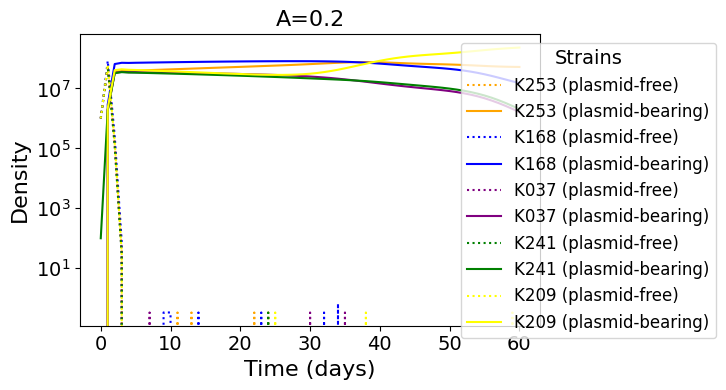

In [11]:
def plotStrainDensitiesOverTime(
    results, num_days, num_species, species_colors, species_labels,
    initial_populations_0, initial_populations_p, title='', outPath=''
):
    """
    Plots the density of each strain (y-axis) against time (x-axis) for plasmid-free and plasmid-bearing subpopulations.

    Parameters:
    results (list): Simulation results containing populations over time.
    num_days (int): Total number of days in the simulation.
    num_species (int): Number of species in the simulation.
    species_colors (list): List of colors for each species.
    species_labels (list): List of labels for each species.
    initial_populations_0 (numpy array): Initial plasmid-free populations [species][SNP][IS].
    initial_populations_p (numpy array): Initial plasmid-bearing populations [species][SNP][IS].
    outPath (str): Path to save the plot (optional).
    """
    days = np.arange(0, num_days + 1)

    # Initialize figure
    fig, ax = plt.subplots(figsize=(8, 4))

    # Iterate through species
    for species_idx in range(num_species):
        # Collect time-series data for plasmid-free and plasmid-bearing populations
        densities_free = []
        densities_bearing = []

        for day in days:
            if day == 0:  # Initial populations
                densities_free.append(initial_populations_0[species_idx].sum())
                densities_bearing.append(initial_populations_p[species_idx].sum())
            else:  # Populations at subsequent days
                densities_free.append(results[day - 1]['final_populations_0'][species_idx].sum())
                densities_bearing.append(results[day - 1]['final_populations_p'][species_idx].sum())

        # Plot densities for plasmid-free (dotted line) and plasmid-bearing (solid line)
        ax.plot(
            days, densities_free, linestyle='dotted', color=species_colors[species_idx],
            label=f"{species_labels[species_idx]} (plasmid-free)"
        )
        ax.plot(
            days, densities_bearing, linestyle='solid', color=species_colors[species_idx],
            label=f"{species_labels[species_idx]} (plasmid-bearing)"
        )

    # Add labels, title, legend, and grid
    ax.set_xlabel('Time (days)', fontsize=16)
    ax.set_ylabel('Density', fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.4, 1), title="Strains", title_fontsize=14)
    ax.set_yscale('log')
    ax.grid(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Adjust layout
    plt.tight_layout()

    # Save or show plot
    if outPath:
        filename = f"{outPath}_strain_densities_over_time.png"
        plt.savefig(filename, format='png', dpi=300)
        print(f"Exporting {filename}")
        plt.close()
    else:
        plt.show()




plotStrainDensitiesOverTime(
    results=results,
    num_days=num_days,
    num_species=num_species,
    species_colors=species_colors,
    species_labels=strainIDs,
    initial_populations_0=populations_0,
    initial_populations_p=populations_p,
    title=f'A={antibiotic_concentration}',
    outPath=''
)



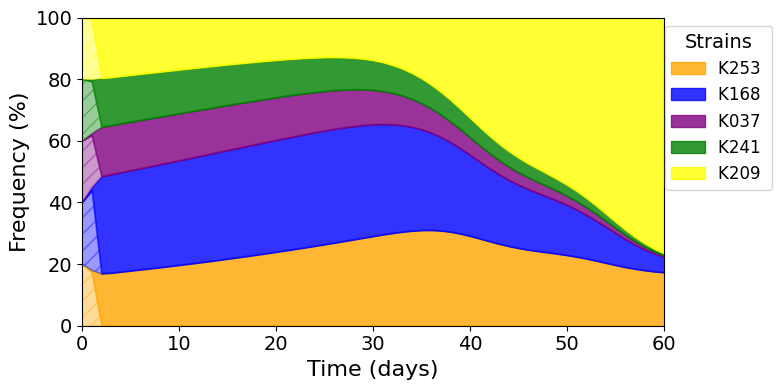

In [12]:
def calculateFrequenciesPerStrain(
    results, num_days, num_species, initial_populations_0, initial_populations_p
):
    """
    Calculates the frequencies per strain per day, normalized by the total population on each day.

    Parameters:
    results (list): Simulation results containing populations over time.
    num_days (int): Total number of days in the simulation.
    num_species (int): Number of species in the simulation.
    initial_populations_0 (numpy array): Initial plasmid-free populations [species][SNP][IS].
    initial_populations_p (numpy array): Initial plasmid-bearing populations [species][SNP][IS].

    Returns:
    dict: A dictionary containing frequencies for plasmid-free and plasmid-bearing strains per species.
    """
    # Create arrays to store the frequencies of plasmid-free and plasmid-bearing populations
    frequencies_free = np.zeros((num_species, num_days + 1))
    frequencies_bearing = np.zeros((num_species, num_days + 1))

    # Calculate total populations per day
    total_populations = []
    for day in range(num_days + 1):
        if day == 0:  # Initial populations (day 0)
            total_population = initial_populations_0.sum() + initial_populations_p.sum()
        else:  # Subsequent days
            total_population = (
                results[day - 1]['final_populations_0'].sum() +
                results[day - 1]['final_populations_p'].sum()
            )
        total_populations.append(total_population)

    total_populations = np.array(total_populations)

    # Iterate over species to calculate frequencies for plasmid-free and plasmid-bearing
    for species_idx in range(num_species):
        for day in range(num_days + 1):
            if day == 0:  # Initial populations (day 0)
                free_pop = initial_populations_0[species_idx].sum()
                bearing_pop = initial_populations_p[species_idx].sum()
            else:  # Subsequent days
                free_pop = results[day - 1]['final_populations_0'][species_idx].sum()
                bearing_pop = results[day - 1]['final_populations_p'][species_idx].sum()

            total_population = total_populations[day]
            # Calculate frequencies for plasmid-free and plasmid-bearing
            frequencies_free[species_idx, day] = free_pop / total_population if total_population > 0 else 0
            frequencies_bearing[species_idx, day] = bearing_pop / total_population if total_population > 0 else 0

    return frequencies_free, frequencies_bearing

def plotStrainFrequenciesStackedArea(
    frequencies_free, frequencies_bearing, num_days, num_species,
    species_colors, species_labels, title='', outPath=''
):
    """
    Plots the frequency of each strain (y-axis) against time (x-axis) using a single stacked area chart,
    combining plasmid-free and plasmid-bearing subpopulations.

    Parameters:
    frequencies_free (numpy array): Array of frequencies for plasmid-free populations [species][days].
    frequencies_bearing (numpy array): Array of frequencies for plasmid-bearing populations [species][days].
    num_days (int): Total number of days in the simulation.
    num_species (int): Number of species in the simulation.
    species_colors (list): List of colors for each species.
    species_labels (list): List of labels for each species.
    outPath (str): Path to save the plot (optional).
    """
    days = np.arange(0, num_days + 1)  # Includes day 0

    # Initialize figure
    fig, ax = plt.subplots(figsize=(8, 4))

    # Storage for cumulative frequencies for stacking
    cumulative_frequencies = np.zeros(len(days), dtype=float)

    for species_idx in range(num_species):
        # Add plasmid-free subpopulation
        prev_cumulative = cumulative_frequencies.copy()
        cumulative_frequencies += frequencies_free[species_idx, :]

        ax.fill_between(
            days, 100 * prev_cumulative, 100 * cumulative_frequencies,
            color=species_colors[species_idx], alpha=0.4, hatch='//'
        )

        # Add plasmid-bearing subpopulation
        prev_cumulative = cumulative_frequencies.copy()
        cumulative_frequencies += frequencies_bearing[species_idx, :]

        ax.fill_between(
            days, 100 * prev_cumulative, 100 * cumulative_frequencies,
            color=species_colors[species_idx], alpha=0.8,
            label=f"{species_labels[species_idx]} "
        )

    # Add labels, title, legend, and grid
    ax.set_xlabel('Time (days)', fontsize=16)
    ax.set_ylabel('Frequency (%)', fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.2, 1), title="Strains", title_fontsize=14)
    ax.set_ylim(0, 100)
    ax.set_xlim(0, num_days)
    ax.grid(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Adjust layout
    plt.tight_layout()

    # Save or show plot
    if outPath:
        filename = f"{outPath}_strain_frequencies_stacked_area.png"
        plt.savefig(filename, format='png', dpi=300)
        print(f"Exporting {filename}")
        plt.close()
    else:
        plt.show()



# Calculate frequencies per day per strain
frequencies_free, frequencies_bearing = calculateFrequenciesPerStrain(
    results=results,
    num_days=num_days,
    num_species=num_species,
    initial_populations_0=populations_0,
    initial_populations_p=populations_p
)

plotStrainFrequenciesStackedArea(frequencies_free, frequencies_bearing, num_days, num_species, species_colors, strainIDs)

Mutation Totals by SNP Level and Frequencies (stacked by Species):
  SNP Level 0: Total Population = 141083721.29823008, Frequency = 46.70%
  SNP Level 1: Total Population = 157573740.99984717, Frequency = 52.16%
  SNP Level 2: Total Population = 3432222.129491764, Frequency = 1.14%

Transposition Totals by IS Level and Frequencies (stacked by Species):
  IS Level 0: Total Population = 18496525.71242591, Frequency = 6.12%
  IS Level 1: Total Population = 135428442.31806722, Frequency = 44.83%
  IS Level 2: Total Population = 148164716.39707592, Frequency = 49.05%

Cumulative Frequencies Excluding Level 0:
  SNP Levels > 0: 53.30%
  IS Levels > 0: 93.88%


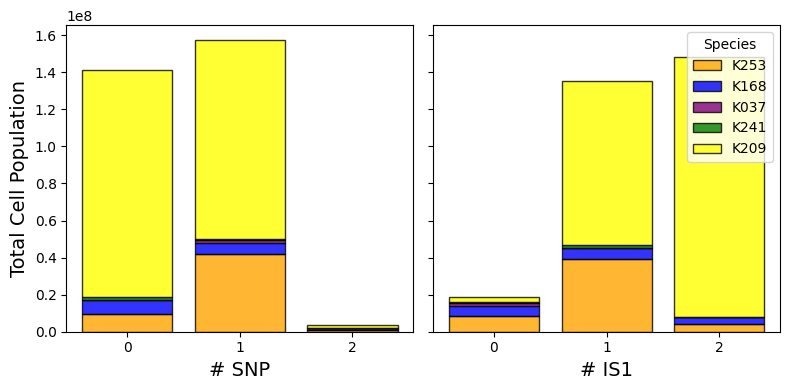

(np.float64(53.29740518430141), np.float64(93.87714090685517))

In [14]:
def plotMutationAndISTranspositionHistogramsFromResults(
    results, Nmuts, Nins, num_species, species_colors, species_labels, outPath=''
):
    """
    Plots stacked histograms showing the distribution of cell populations across mutation levels and IS transpositions
    for multiple species from the simulation `results`.

    Parameters:
    results (list of dict): Simulation results containing final populations over days.
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    num_species (int): Number of species.
    species_colors (list): List of colors for each species.
    species_labels (list): Labels for each species.
    outPath (str): Path to save the plot (optional).
    """
    # Initialize arrays to store cumulative populations across days
    total_populations_mutations = np.zeros((num_species, Nmuts))
    total_populations_transpositions = np.zeros((num_species, Nins))

    # Iterate over results to accumulate final populations
    for day_result in [results[-1]]: #final day
        final_populations_0 = day_result["final_populations_0"]
        final_populations_p = day_result["final_populations_p"]

        # Sum populations by SNP (axis 2) and IS (axis 1)
        total_populations_mutations += final_populations_0.sum(axis=2) + final_populations_p.sum(axis=2)
        total_populations_transpositions += final_populations_0.sum(axis=1) + final_populations_p.sum(axis=1)

    # Total population across all SNP and IS levels
    total_population = total_populations_mutations.sum()

    # Variables to store cumulative frequencies excluding Level 0
    snp_cumulative_freq = 0
    is_cumulative_freq = 0

    # Debugging print statements to verify calculations
    print("Mutation Totals by SNP Level and Frequencies (stacked by Species):")
    for level in range(Nmuts):
        level_total = total_populations_mutations[:, level].sum()
        frequency = (level_total / total_population) * 100 if total_population > 0 else 0
        print(f"  SNP Level {level}: Total Population = {level_total}, Frequency = {frequency:.2f}%")
        if level > 0:  # Exclude Level 0
          snp_cumulative_freq += frequency

    print("\nTransposition Totals by IS Level and Frequencies (stacked by Species):")
    for level in range(Nins):
        level_total = total_populations_transpositions[:, level].sum()
        frequency = (level_total / total_population) * 100 if total_population > 0 else 0
        print(f"  IS Level {level}: Total Population = {level_total}, Frequency = {frequency:.2f}%")
        if level > 0:  # Exclude Level 0
          is_cumulative_freq += frequency

    # Display cumulative frequencies
    print("\nCumulative Frequencies Excluding Level 0:")
    print(f"  SNP Levels > 0: {snp_cumulative_freq:.2f}%")
    print(f"  IS Levels > 0: {is_cumulative_freq:.2f}%")

    # Plot histograms
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

    # Stacked SNP-level histogram
    bottom = np.zeros(Nmuts)
    for species_idx in range(num_species):
        axes[0].bar(
            range(Nmuts),
            total_populations_mutations[species_idx],
            bottom=bottom,
            color=species_colors[species_idx],
            edgecolor='black',
            label=species_labels[species_idx],
            alpha=0.8,
        )
        bottom += total_populations_mutations[species_idx]
    axes[0].set_xlabel('# SNP', fontsize=14)
    axes[0].set_ylabel('Total Cell Population', fontsize=14)
    axes[0].set_xticks(range(Nmuts))

    #axes[0].set_yscale('log')
    #axes[0].set_ylim([1, 1e9])
    #axes[0].legend(fontsize=10, title='Species', loc='upper left')

    # Stacked IS-level histogram
    bottom = np.zeros(Nins)
    for species_idx in range(num_species):
        axes[1].bar(
            range(Nins),
            total_populations_transpositions[species_idx],
            bottom=bottom,
            color=species_colors[species_idx],
            edgecolor='black',
            label=species_labels[species_idx],
            alpha=0.8,
        )
        bottom += total_populations_transpositions[species_idx]
    axes[1].set_xlabel('# IS1', fontsize=14)
    #axes[1].set_yscale('log')
    #axes[1].set_ylim([1, 1e9])
    axes[1].legend(fontsize=10, title='Species', loc='upper right')
    axes[1].set_xticks(range(Nins))


    # Adjust layout
    plt.tight_layout()

    if outPath:
        filename = f"{outPath}_mutation_transposition_histograms_stacked.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight')
        print(f"Exporting {filename}")
        plt.close()
    else:
        plt.show()

    return snp_cumulative_freq, is_cumulative_freq



plotMutationAndISTranspositionHistogramsFromResults(
    results=results,
    Nmuts=num_mutationsSNP,
    Nins=num_mutationsIS,
    num_species=num_species,
    species_colors=species_colors,
    species_labels=strainIDs,
    outPath=''
)

In [15]:
import numpy as np

def computeAccumulatedMutations(results, Nmuts, Nins, num_species):
    """
    Computes the total number of accumulated mutations (SNPs + IS1s) for each species.

    Parameters:
    results (dict): Simulation results for a single case.
    Nmuts (int): Number of mutation levels.
    Nins (int): Number of transposition levels.
    num_species (int): Number of species/strains.

    Returns:
    np.array: A 1D array (species) containing the total number of accumulated mutations per species.
    """
    accumulated_mutations = np.zeros(num_species)

    # Get the final day's population data
    final_day = results[-1]  # Get the last recorded time point
    final_populations_0 = final_day["final_populations_0"]  # Plasmid-free
    final_populations_p = final_day["final_populations_p"]  # Plasmid-bearing

    # Compute total accumulated mutations per species
    for species_idx in range(num_species):
        # SNP Mutations: Weight by level
        for level in range(1, Nmuts):  # Skip level 0 (non-mutant)
            accumulated_mutations[species_idx] += level * np.sum(final_populations_0[species_idx, level, :])
            accumulated_mutations[species_idx] += level * np.sum(final_populations_p[species_idx, level, :])

        # IS Transpositions: Weight by level
        for level in range(1, Nins):  # Skip level 0 (non-mutant)
            accumulated_mutations[species_idx] += level * np.sum(final_populations_0[species_idx, :, level])
            accumulated_mutations[species_idx] += level * np.sum(final_populations_p[species_idx, :, level])

    return accumulated_mutations


total_mutant_cells = computeAccumulatedMutations(results, num_mutationsSNP, num_mutationsIS, num_species)

print("Total Mutant Cells Per Species:")
print(total_mutant_cells)


Total Mutant Cells Per Species:
[9.14687696e+07 2.18237162e+07 1.81132781e+06 2.25238417e+06
 4.78839863e+08]
